## Introduction to ORB and Keypoint Detection

Objective: Familiarize yourself with ORB (Oriented FAST and Rotated BRIEF), a feature detector and descriptor. You'll load images, detect keypoints, and extract ORB descriptors.

### ORB (Oriented FAST and Rotated BRIEF)

ORB is a fast robust local feature detector, first introduced by Ethan Rublee, Vincent Rabaud, Kurt Konolige, and Gary R. Bradski in their 2011 paper. ORB is essentially a fusion of FAST keypoint detector and BRIEF descriptor with some modifications to enhance performance. It is designed to be faster and more efficient than its predecessors like SIFT and SURF while providing good resistance to noise and being able to handle rotation changes efficiently. Here's a detailed explanation of how ORB works:

1. FAST Keypoint Detection
ORB starts with a FAST (Features from Accelerated Segment Test) detector to find keypoints. The FAST detector identifies corners in an image by considering a circle of sixteen pixels around the candidate pixel. It classifies a pixel as a corner if there are n contiguous pixels in the circle which are all brighter than the candidate pixel plus a threshold or all darker than the candidate pixel minus a threshold. The original FAST does not compute the orientation of keypoints, which is necessary for achieving rotation invariance.

2. Orientation Computation
To add orientation to the keypoints, ORB computes the intensity weighted centroid of a patch around the keypoint. The vector from the center of the patch to this centroid gives the orientation. This method ensures that the orientation is invariant to scale and rotation.

3. Harris Corner Measure
Although FAST is good at detecting keypoints, it selects too many. To reduce the number and only keep the most prominent ones, ORB uses the Harris corner measure to rank the keypoints. It then selects the top N keypoints based on the Harris score (or FAST score if Harris is not preferred due to performance reasons).

4. BRIEF Descriptor
After detecting and orienting the keypoints, ORB uses a modified version of the BRIEF (Binary Robust Independent Elementary Features) descriptor to generate a feature descriptor for each keypoint. BRIEF creates a binary string description of an image patch by comparing the intensity of pairs of pixels in a small region around the keypoint.

5. Rotation Awareness and Steering
The original BRIEF descriptor is not rotation invariant, which is a problem for matching keypoints between images that have been rotated relative to each other. To solve this, ORB steers the BRIEF according to the orientation of keypoints. This means rotating the BRIEF's pattern to match the keypoint's orientation, ensuring that the descriptor is rotation invariant.

6. Scale Invariance
ORB achieves scale invariance by constructing a pyramid of down-scaled images. Keypoints are detected at each level of the pyramid, which allows ORB to detect and match features across images with different scales.

7. Fast Binary Descriptor Matching
The binary nature of the ORB descriptor allows for using the Hamming distance to compare descriptors, which can be done very efficiently with modern CPUs, especially using popcount (counting the number of set bits in a binary word) instructions. This efficiency makes ORB particularly well-suited for real-time applications.

Summary
ORB is a powerful feature detector and descriptor that offers a good balance between speed, efficiency, and performance. It does so by cleverly integrating and modifying existing algorithms (FAST and BRIEF) and adding mechanisms to ensure rotation and scale invariance, making it suitable for a wide range of computer vision applications, especially those requiring real-time performance.

**Create ORB descriptor**

Load two images: 'box.png' as the query image and 'box_in_scene.png' as the train image.

Use cv.imread with cv.IMREAD_GRAYSCALE to load images in grayscale.

Initialize the ORB detector using `ORB_create`.

Detect keypoints and compute descriptors for both images using orb.

`detectAndCompute`

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt

# Task 1: Load images in grayscale
img1 = cv.imread('box.png', cv.IMREAD_GRAYSCALE)
img2 = cv.imread('box_in_scene.png', cv.IMREAD_GRAYSCALE)

In [2]:
img1.shape, img2.shape

((223, 324), (384, 512))

Display both images

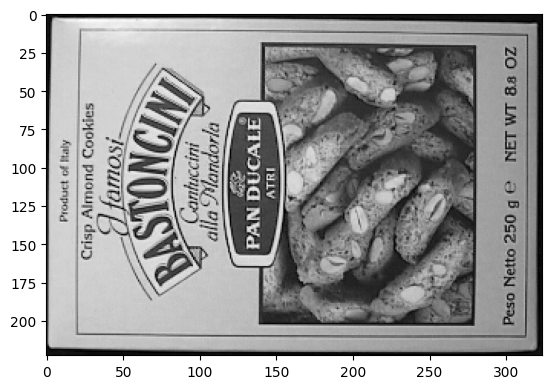

In [3]:
plt.imshow(img1, cmap='gray')

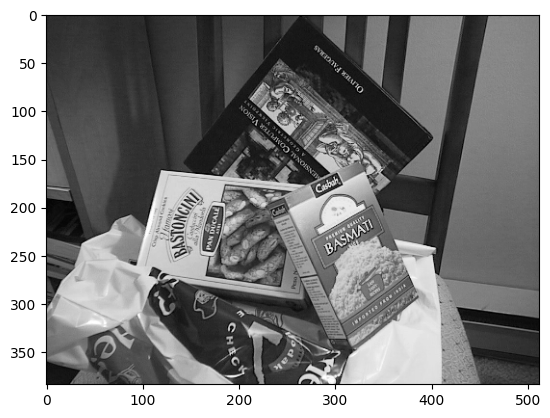

In [4]:
plt.imshow(img2, cmap='gray')

In [5]:
# Task 2: Initiate ORB detector
orb = cv.ORB_create()

In [6]:
# Task 3: Detect keypoints and compute descriptors
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

**Implementing Brute-Force Matching with ORB Descriptors**

Objective: Learn how to use the Brute-Force matcher to find matches between descriptors of two images.

Brute-Force matcher:

- The BFMatcher takes each descriptor from the first set and compares it against all descriptors in the second set using a distance metric.

- The match between two descriptors is determined based on the distance metric. The lower the distance, the better the match. For binary descriptors, the Hamming distance is often preferred as it is faster to compute, especially with hardware support for popcount operations.

BFMatcher provides two primary methods for retrieving matches:

match(): This method finds the best match for each descriptor in the first set. It returns a list of the best matches, each of which corresponds to a single descriptor comparison. This is useful when you only need the best match for each feature.

knnMatch(): This method finds the top k matches for each descriptor in the first set, where k is specified by the user. This is particularly useful for applying filters on the matches, such as the Lowe's ratio test, which compares the distance of the best match to the distance of the second-best match to discard poor matches.



Tasks:

Create a BFMatcher object with cv.NORM_HAMMING and crossCheck=True.
Match descriptors using the match() method of BFMatcher. Have a look at the documentation of OpenCV.

Sort the matches based on their distance.

Draw the top 10 matches using cv.drawMatches and display the result with plt.imshow().


In [7]:
# Task 1: Create BFMatcher object
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)

In [8]:
# Task 2: Match descriptors
matches = bf.match(des1, des2)

In [9]:
# Task 3: Sort matches
matches = sorted(matches, key=lambda x: x.distance)

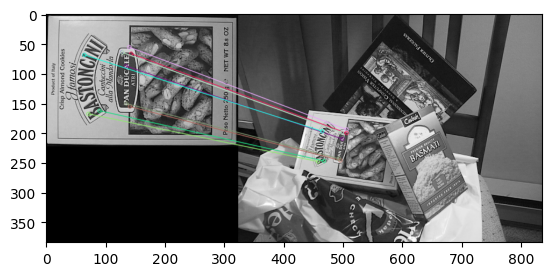

In [10]:
# Task 4: Draw and display matches
img3 = cv.drawMatches(img1, kp1, img2, kp2, matches[:10], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3)
plt.show()

**Applying Lowe's Ratio Test for Reliable Matching**

Objective: Apply Lowe's ratio test to filter out unreliable matches. This method helps in reducing false positives.

Tasks:

Use knnMatch() of BFMatcher to find the 2 best matches for each descriptor.
Apply Lowe's ratio test (e.g., if the distance of the best match is less than 75% of the second-best match, keep this match).

Draw and display the good matches that pass the ratio test.


In [13]:
# Task 1: Find 2 best matches for each descriptor
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=False)
matches = bf.knnMatch(des1, des2, k=2)

In [14]:
# Task 2: Apply Lowe's ratio test
good = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good.append([m])

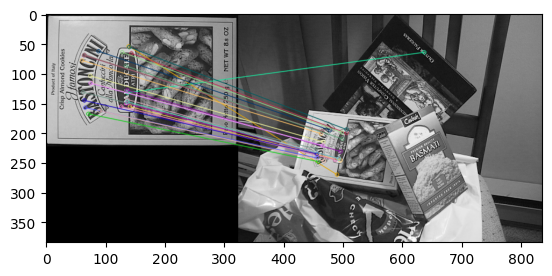

In [15]:
# Task 3: Draw and display good matches
img3 = cv.drawMatchesKnn(img1, kp1, img2, kp2, good, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3)
plt.show()

**Exploring FLANN Based Matcher**

Objective: Experiment with the FLANN based matcher, which is more suitable for large datasets or high-dimensional features.

The FLANN based matcher (Fast Library for Approximate Nearest Neighbors) is an algorithm used for efficiently finding approximate nearest neighbors in large datasets or high-dimensional spaces. In the context of computer vision, FLANN is used to match feature descriptors between images more quickly than a brute-force approach, especially when dealing with a large number of features. It is particularly useful in applications requiring fast performance, such as real-time image matching, object recognition, and 3D reconstruction.


Tasks:

Define FLANN matcher parameters and initialize the FLANN matcher.
Use knnMatch() to find matches and apply Lowe's ratio test.
Draw the good matches and display the result.

In [17]:
# Task 1: Define FLANN matcher parameters and initialize
index_params = dict(algorithm=6, table_number=6, key_size=12, multi_probe_level=1)  # For ORB
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params, search_params)

In [20]:
flann

< cv2.FlannBasedMatcher 0x7d66df6234d0>

In [24]:
# Task 2: Find matches and apply Lowe's ratio test
matches = flann.knnMatch(des1, des2, k=2)
good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]
good_matches_for_drawing = [[m] for m in good_matches]

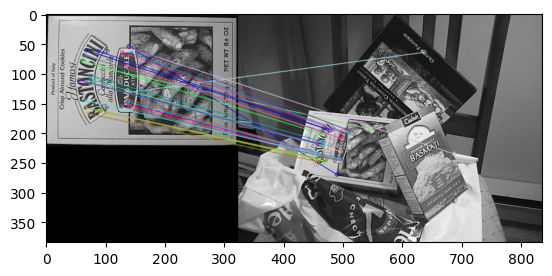

In [25]:
# Task 3: Draw and display good matches
img3 = cv.drawMatchesKnn(img1, kp1, img2, kp2, good_matches_for_drawing, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the result
plt.imshow(img3)
plt.show()